In [1]:
import numpy as np
import os
import copy
import functools

import pickle as pk
from PIL import Image, ImageOps

import matplotlib.pyplot as plt
import seaborn as sns

#import SP_dataset


In [2]:
#%%
from diskcache import FanoutCache, Disk
import logging

log = logging.getLogger(__name__)
# log.setLevel(logging.WARN)
# log.setLevel(logging.INFO)
log.setLevel(logging.DEBUG)

def getCache(scope_str):
    return FanoutCache('./tmp/cache/' + scope_str,
                       #disk=GzipDisk,
                       shards=64,
                       timeout=1,
                       size_limit=3e11,
                       # disk_min_file_size=2**20,
                       )

raw_cache = getCache('soil')

## Data extraction

In [3]:
from sklearn.neighbors import KernelDensity

@functools.lru_cache(1)

def Get_images_list(folder_path):
    #input: path as str
    #output: image path array, target array
    
    assert os.path.exists(folder_path), "Selected path doesn't exists"
    
    f_paths = []

    for src_p, folder_p, f_names in os.walk('./PanelImages/'):
        for f_name in f_names:
            if src_p[-1]!='/':
                src_p = src_p+'/'
            f_paths.append(src_p+f_name)

    loss_arr = np.array([float(x.split('L_')[-1].split('_I')[0]) for x in f_paths])
    
    return np.array(f_paths), loss_arr

def plot_dist(values):
    #input: array 1-D
    #output: kde + hist plot
    
    
    fig, axs = plt.subplots(figsize=(8,5))

    axs.hist(values, density=True, bins=30, alpha=.8, color='darkred')
    p = sns.kdeplot(values, ax=axs, color='darkblue')
 
    axs.grid()
    plt.show()
    

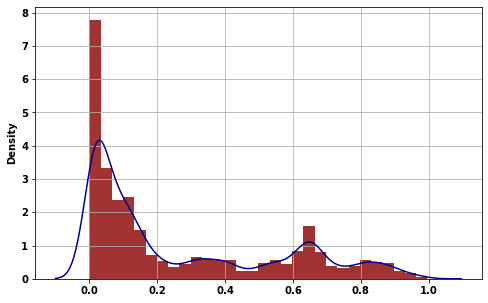

In [4]:
paths_list, targets = Get_images_list('./PanelImages/')
plot_dist(targets)

## Train & Test Split

In [5]:
def Get_test_indx(targets, test_split=0.0, random_state=24):
    #inputs: numpy.array-like
    #outputs: test_indexes
    
    bins = np.arange(0,1.1,.1)
    
    class_arr = np.digitize(targets, bins, right=False)
    #class_arr and targets has the same size
    
    total_test_idx = []
    
    np.random.seed(random_state)
    for class_i in np.unique(class_arr):
        
        class_idx_i = np.nonzero(class_arr==class_i)[0]
        
        test_idx_i = np.random.choice(class_idx_i, 
                              round(class_idx_i.shape[0]*test_split),
                              replace=False)

        total_test_idx.extend(test_idx_i)
    
    return total_test_idx

def Train_Test_Split(x, y, test_split=0.0, random_state=24):
    test_indexes = Get_test_indx(y, test_split=test_split, random_state=random_state)
    
    return np.delete(x,test_indexes,0), x[test_indexes], np.delete(y,test_indexes,0), y[test_indexes]

In [6]:
X_train, X_test, y_train, y_test = Train_Test_Split(paths_list, targets, test_split=.2, random_state=24)

In [7]:
X_train.shape

(36603,)

In [8]:
y_test.shape

(9151,)

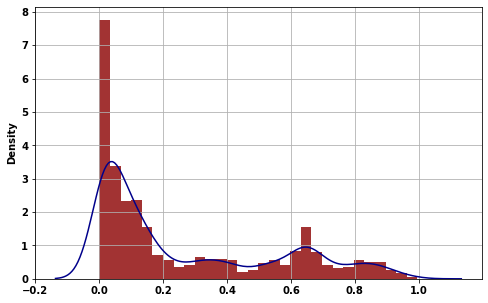

In [9]:
plot_dist(y_test)

## Training dataset

In [10]:
import torch
from torch.utils.data import DataLoader, Dataset
##
#Create dataset


@raw_cache.memoize(typed=True)
def Get_image(img_path):
    return np.array(ImageOps.grayscale(Image.open(img_path)).resize((28,28)))


class SoilDataset(Dataset):

    def __init__(self,
                 images_paths,
                 target_arr,
                 val_side = False,
                 val_split = 0.0,
                 random_state = 24,
                 classic_ml = False,
                 normalize=False):
        
        self.targets = target_arr
        self.data_path = images_paths

        self.classic_ml = classic_ml
        self.normalize = normalize
        
        if val_split>0:
            assert val_split<=1, '"val_split" must be between 0 to 1.0'
            np.random.seed(random_state)

            test_indexes = np.random.choice(self.data_path.shape[0],
                                           int(self.data_path.shape[0]*val_split),
                                           replace=False)            

            if val_side:
                self.data_path = self.data_path[test_indexes]
                self.targets = self.targets[test_indexes]
            else:
                self.data_path = np.delete(self.data_path, test_indexes, 0)
                self.targets = np.delete(self.targets, test_indexes, 0)
        

    def __len__(self):
        return self.data_path.shape[0]


    def __getitem__(self, index):

        x = Get_image(self.data_path[index])
        y = self.targets[index]
        
        if self.normalize:
            x = x/255

        if self.classic_ml:
            x = torch.from_numpy(x.reshape(1,-1)).float()
        else:
            x = torch.from_numpy(x).float()

        return x, torch.tensor(y).float()


In [11]:
def show_me_image(img, img_label='unknown'):
    #input: torch tensor
    #output: image show
    img_arr = copy.copy(img)
    img_label_arr = copy.copy(img_label)
    if type(img).__module__=='torch':
        img_arr = img_arr.numpy()
        img_label_arr = img_label_arr.numpy()
    
    img_arr = img.reshape(-1,28)
    
    fig, ax = plt.subplots(figsize=(5,5))
    
    ax.imshow(img_arr, cmap='gray')
    ax.text(1,1,img_label_arr)
    plt.show()

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


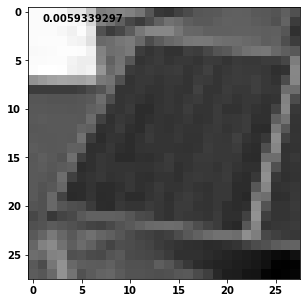

In [13]:
# get some random training images

#Dataloader
soil_dataset = SoilDataset(images_paths=X_train,
                           target_arr=y_train,
                           classic_ml=False,
                           normalize=True)

train_dataloader = DataLoader(soil_dataset, batch_size=64, shuffle=True)
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

#images display:

show_me_image(images[0], labels[0])

## Neural Network class:

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class nn_model(nn.Module):
    def __init__(self):
        super(nn_model, self).__init__()
 
        #model arch:
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 256)
        self.outl = nn.Linear(256,1)
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.sigmoid(self.outl(x))
        return x
    

my_net = nn_model()
my_net.to(device)
print(my_net)

nn_model(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=256, bias=True)
  (outl): Linear(in_features=256, out_features=1, bias=True)
)


### Training parameters:

In [15]:
# Training parameters:
epochs = 200
batch_size = 64

learning_rate = 0.0001

train_dataset = SoilDataset(images_paths=X_train,
                            target_arr=y_train,
                            val_side=False,
                            val_split = .2,
                            random_state=42,
                            classic_ml=True,
                            normalize=True)

val_dataset = SoilDataset(images_paths=X_train,
                            target_arr=y_train,
                            val_side=True,
                            val_split = .2,
                            random_state=42,
                            classic_ml=True,
                            normalize=True)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


#Loss function:
criterion = nn.MSELoss()

#Optimizer:
optimizer = torch.optim.Adam(my_net.parameters(), lr = learning_rate)

## Training

In [16]:
epoch_loss = []
val_loss = []
for epoch in range(epochs): 
    
    running_loss = 0.0

    for i, data in enumerate(train_dataloader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward:
        outputs = my_net(inputs).reshape(-1,1)
        
        #loss:
        loss = criterion(outputs, labels.unsqueeze(1))
        
        #backpropagation:
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()*inputs.size(0)
        
    running_loss = running_loss/train_dataset.__len__()
    epoch_loss.append(running_loss)
    
    val_i_loss = 0
    for i, val_data in enumerate(val_dataloader):
        val_i_loss += criterion(my_net(val_data[0].to(device)).reshape(-1,1), 
                                val_data[1].to(device).unsqueeze(1)).item()*val_data[0].size(0)
    val_loss.append(val_i_loss/val_dataset.__len__())
    
    
    print(f'epoch {epoch:04d} of {epochs:04d} | loss: {running_loss:.4f} - val_loss: {val_loss[-1]:.4f}         ', end='\r')
    if (epoch+1)%10==0:
        print(f'\nepoch: {epoch+1}')

print('Finished Training')

epoch 0009 of 0200 | loss: 0.0137 - val_loss: 0.0128         
epoch: 10
epoch 0019 of 0200 | loss: 0.0121 - val_loss: 0.0132         
epoch: 20
epoch 0029 of 0200 | loss: 0.0111 - val_loss: 0.0120         
epoch: 30
epoch 0039 of 0200 | loss: 0.0103 - val_loss: 0.0126         
epoch: 40
epoch 0049 of 0200 | loss: 0.0097 - val_loss: 0.0103         
epoch: 50
epoch 0059 of 0200 | loss: 0.0095 - val_loss: 0.0126         
epoch: 60
epoch 0069 of 0200 | loss: 0.0082 - val_loss: 0.0084         
epoch: 70
epoch 0079 of 0200 | loss: 0.0083 - val_loss: 0.0082         
epoch: 80
epoch 0089 of 0200 | loss: 0.0079 - val_loss: 0.0083         
epoch: 90
epoch 0099 of 0200 | loss: 0.0086 - val_loss: 0.0100         
epoch: 100
epoch 0109 of 0200 | loss: 0.0078 - val_loss: 0.0077         
epoch: 110
epoch 0119 of 0200 | loss: 0.0072 - val_loss: 0.0085         
epoch: 120
epoch 0129 of 0200 | loss: 0.0076 - val_loss: 0.0074         
epoch: 130
epoch 0139 of 0200 | loss: 0.0070 - val_loss: 0.0083        

In [17]:
def plot_training_graph(train_hist, val_hist):
    fig, axs = plt.subplots(figsize=(8,5))
    
    axs.plot(train_hist, label='train loss', color='darkblue')
    axs.plot(val_hist, label='val loss', color='darkred')
    
    axs.set_ylim([0, max(train_hist + val_hist)+ np.std(train_hist + val_hist)])
    axs.set_xlabel('Epoch')
    axs.set_ylabel('Loss')
    axs.legend()
    axs.grid()
    plt.show()

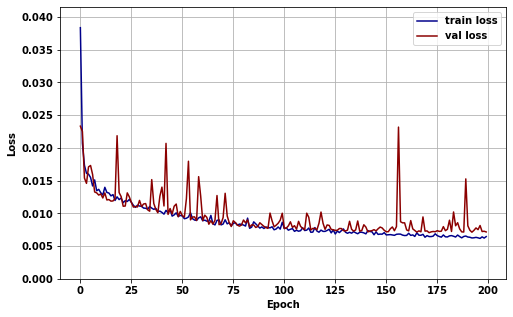

In [18]:
plot_training_graph(epoch_loss, val_loss)

In [19]:
model_path = './Soil_model_v2.pth'

In [20]:
torch.save(my_net.state_dict(), model_path)

In [21]:
my_model = nn_model()
my_model.load_state_dict(torch.load(model_path))
my_model.eval()

nn_model(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=256, bias=True)
  (outl): Linear(in_features=256, out_features=1, bias=True)
)

## Evaluation

In [22]:
test_dataset = SoilDataset(images_paths=X_test,
                            target_arr=y_test,
                            random_state=42,
                            classic_ml=True,
                            normalize=True)

test_dataloader = DataLoader(test_dataset, batch_size=test_dataset.__len__())


In [23]:
my_model.to(device)
for i, data in enumerate(test_dataloader, 0):
    inputs, labels = data[0].to(device), data[1].to(device)

    outputs = my_model(inputs)
outputs.shape

torch.Size([9151, 1, 1])

In [24]:
y_hat = outputs.reshape(-1,1).cpu().detach().numpy()

y_hat[:5]

array([[0.06975151],
       [0.02610777],
       [0.01626912],
       [0.18239082],
       [0.0380908 ]], dtype=float32)

In [25]:
from sklearn.metrics import r2_score, mean_squared_error

r2_score(y_test.reshape(-1,1), y_hat)

0.9185235293421649

In [26]:
mean_squared_error(y_test.reshape(-1,1), y_hat)

0.0065645272007163035

In [27]:
def plot_residplot(y_true, y_hat):
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    resid = y_true - y_hat
    axs[0].scatter(y_hat, resid, edgecolors='whitesmoke')
    axs[0].set_title('Residual plot')
    axs[0].set_xlabel('y hat')
    axs[0].set_ylabel('Residuals')
    axs[0].grid()
    
    p = sns.kdeplot(resid, ax=axs[1], color='k')
    axs[1].hist(resid, density=True, bins=30, alpha=.7)
    axs[1].set_title('Error distribution')
    axs[1].set_ylabel('count')
    axs[1].grid()
    
    plt.show()

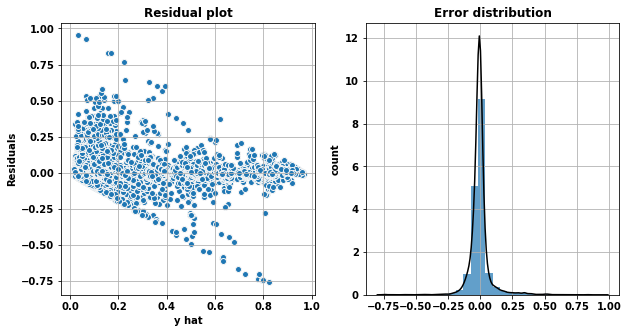

In [28]:
plot_residplot(y_test.reshape(-1,), y_hat.reshape(-1,))